#Import Library

In [1]:
import os
import glob
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn.metrics

from keras_preprocessing.image import ImageDataGenerator
from keras import models, layers, optimizers
from keras.models import  Model, Sequential
from keras.layers import Dense, Dropout, Flatten, Activation, GlobalAveragePooling2D, BatchNormalization, Concatenate
from keras.callbacks import EarlyStopping
from keras.layers.convolutional import Conv1D, Conv2D, MaxPooling2D
from keras.utils import np_utils

from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import top_k_accuracy_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer
import pandas as pd

plt.style.use('ggplot')

In [2]:
#Test GPU
tf.test.gpu_device_name()

'/device:GPU:0'

# ResNet50 Model 5

In [3]:
from tensorflow.keras.applications import ResNet50
#Load the ResNet50 model
ResNet50_conv = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in ResNet50_conv.layers:
    layer.trainable = True

# Check the trainable status of the individual layers
for layer in ResNet50_conv.layers:
    print(layer, layer.trainable)

# Create the model
model = models.Sequential()
# Add the convolutional base model
model.add(ResNet50_conv)

# Add new layers
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(13, activation='softmax'))

94781440/94765736 [==============================] - 0s 0us/step
<keras.engine.input_layer.InputLayer object at 0x7f8310856e10> True
<keras.layers.convolutional.ZeroPadding2D object at 0x7f830741bb10> True
<keras.layers.convolutional.Conv2D object at 0x7f8307664550> True
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f828a2e2390> True
<keras.layers.core.activation.Activation object at 0x7f830741bb90> True
<keras.layers.convolutional.ZeroPadding2D object at 0x7f8308fcd110> True
<keras.layers.pooling.MaxPooling2D object at 0x7f828a239350> True
<keras.layers.convolutional.Conv2D object at 0x7f828a24e1d0> True
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f828a255710> True
<keras.layers.core.activation.Activation object at 0x7f828a25c790> True
<keras.layers.convolutional.Conv2D object at 0x7f828a261790> True
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f828a259e50> True
<keras.layers.core.

In [4]:
# Show a summary of the model. Check the number of trainable parameters
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 512)               51380736  
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 batch_normalization_1 (Batc  (None, 128)              512       
 hNormalization)                                        

In [5]:
 # Compile the model
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001, rho=0.9)
model.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])

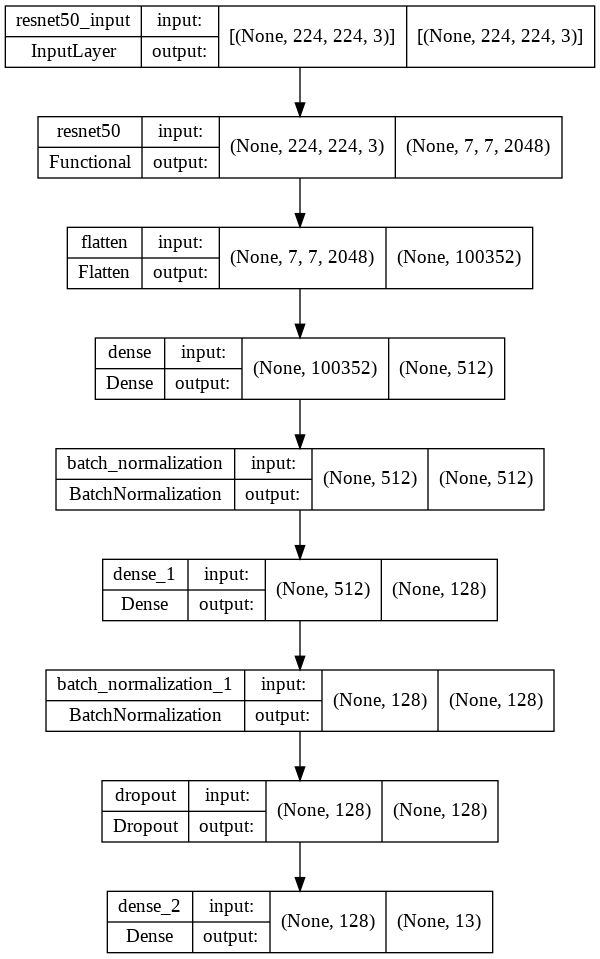

In [6]:
from keras.utils.vis_utils import plot_model

plot_model(model, show_shapes=True, show_layer_names = True)
from IPython.display import Image
Image(filename='model.png')

In [7]:
%matplotlib inline
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [8]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = False)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [9]:
training_set = train_datagen.flow_from_directory('/content/drive/MyDrive/Birddata_split/New_8_1/train/',
                                                 target_size = (224, 224),
                                                 shuffle=True)

Found 10590 images belonging to 13 classes.


In [10]:
test_set = test_datagen.flow_from_directory('/content/drive/MyDrive/Birddata_split/New_8_1/val/',
                                            target_size = (224, 224), shuffle=False)

Found 1303 images belonging to 13 classes.


In [11]:
for cls, idx in training_set.class_indices.items():
    print('Class nr ',idx,' -> ', cls)

Class nr  0  ->  0Capri
Class nr  1  ->  10Pachy
Class nr  2  ->  12Phyll
Class nr  3  ->  14Macro
Class nr  4  ->  1Pnoep
Class nr  5  ->  2Malac
Class nr  6  ->  3Malac
Class nr  7  ->  4Anthi
Class nr  8  ->  5Anthr
Class nr  9  ->  6Corvu
Class nr  10  ->  7Dryoc
Class nr  11  ->  8Elanu
Class nr  12  ->  9Ortho


In [12]:
model_history = model.fit(training_set, batch_size=16, epochs=10, verbose=1, validation_data=(test_set))

Epoch 1/10
331/331 [==============================] - 3960s 12s/step - loss: 0.7688 - accuracy: 0.7777 - val_loss: 2.7102 - val_accuracy: 0.1036
Epoch 2/10
331/331 [==============================] - 167s 505ms/step - loss: 0.3440 - accuracy: 0.8996 - val_loss: 2.4878 - val_accuracy: 0.2064
Epoch 3/10
331/331 [==============================] - 166s 500ms/step - loss: 0.2285 - accuracy: 0.9329 - val_loss: 1.5538 - val_accuracy: 0.5955
Epoch 4/10
331/331 [==============================] - 167s 504ms/step - loss: 0.1486 - accuracy: 0.9555 - val_loss: 0.4649 - val_accuracy: 0.8711
Epoch 5/10
331/331 [==============================] - 166s 502ms/step - loss: 0.1050 - accuracy: 0.9701 - val_loss: 0.4780 - val_accuracy: 0.8887
Epoch 6/10
331/331 [==============================] - 167s 503ms/step - loss: 0.0835 - accuracy: 0.9759 - val_loss: 0.4837 - val_accuracy: 0.8826
Epoch 7/10
331/331 [==============================] - 166s 502ms/step - loss: 0.0532 - accuracy: 0.9855 - val_loss: 0.4511 - 

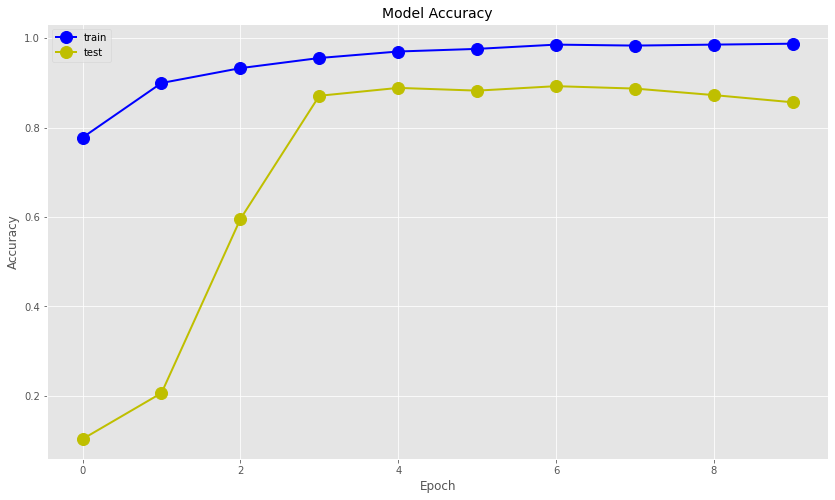

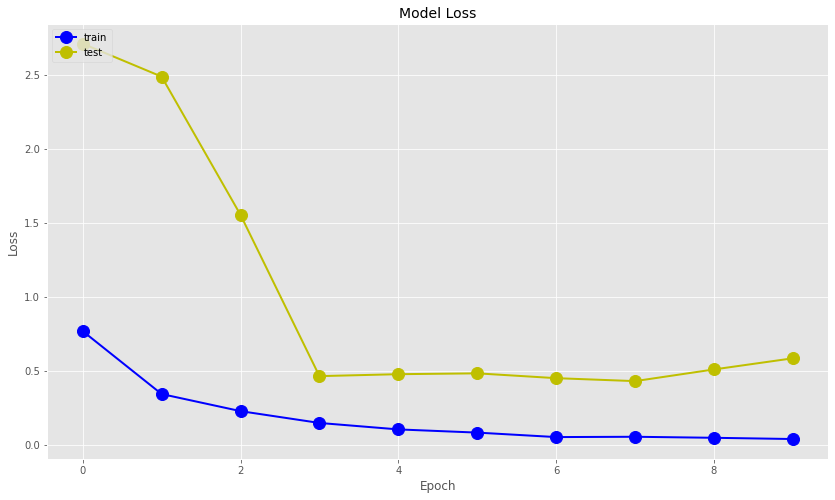

In [13]:
plt.figure(figsize=(14,8))
plt.plot(model_history.history['accuracy'], 'bo-', linewidth=2, markersize=12)
plt.plot(model_history.history['val_accuracy'], 'yo-', linewidth=2, markersize=12)
plt.title('Model Accuracy', fontsize=14)
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend(['train', 'test'], loc='upper left')
plt.show()

 # summarize history for loss
plt.figure(figsize=(14,8))
plt.plot(model_history.history['loss'], 'bo-', linewidth=2, markersize=12 )
plt.plot(model_history.history['val_loss'], 'yo-', linewidth=2, markersize=12)
plt.title('Model Loss', fontsize=14)
plt.ylabel('Loss',fontsize=12)
plt.xlabel('Epoch',fontsize=12)
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [14]:
target_names = []
for key in training_set.class_indices:
  target_names.append(key)

print(target_names)

['0Capri', '10Pachy', '12Phyll', '14Macro', '1Pnoep', '2Malac', '3Malac', '4Anthi', '5Anthr', '6Corvu', '7Dryoc', '8Elanu', '9Ortho']


# Confussion Matrix

41/41 [==============================] - 7s 174ms/step - loss: 0.5854 - accuracy: 0.8565
n Test_Accuracy:- 0.8564850091934204
confusion matrix
[[ 69   1   1   0   3   0   0   0   0   3   3   0   0]
 [  7  27   0   0   5   1   8   0   0   0   5   1   0]
 [  0   0 271   0   3   1   0   0   0   0   0   2   0]
 [  0   0  10 157   4   0   1   0   0   0   5   6   0]
 [  0   0   3   0 137   6   0   1   0   0   0   1   0]
 [  1   1   0   0   0  53   3   0   0   2   2   0   0]
 [  1   0   6   1   1   3  59   0   0   0   5   4   0]
 [  0   0   2   0   3   0   0  33   0   0   0   2   0]
 [  3   0   1   2   2   0   3   0  32   0   3   2   0]
 [  3   1   6   0   0   0   0   0   0  55   1   5   0]
 [  0   0   1   0   0   3   4   0   5   2  43   0   0]
 [  0   0   1   0   0   0   0   0   0   0   0 137   0]
 [  0   4   4   0   0   5   2   0   1   0   2   3  43]]


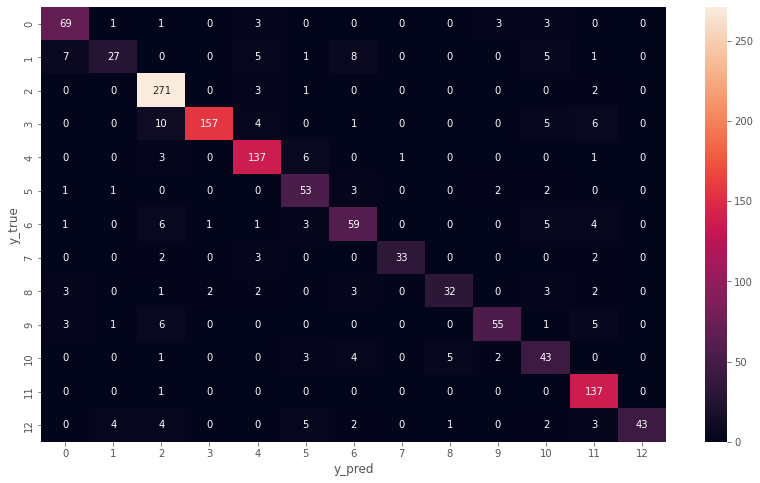

In [15]:
accuracy = model.evaluate(test_set)
print('n', 'Test_Accuracy:-', accuracy[1])
pred = model.predict(test_set)
y_pred = np.argmax(pred, axis=1)
#y_true = np.argmax(pred, axis=1)
print('confusion matrix')
print(confusion_matrix(test_set.classes, y_pred))
    #confusion matrix
f, ax = plt.subplots(figsize=(14,8))
sns.heatmap(confusion_matrix(test_set.classes, y_pred), annot=True, fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

# Classification Report

In [25]:
print('Classification Report')
print(classification_report(test_set.classes, y_pred, target_names=target_names ))

Classification Report
              precision    recall  f1-score   support

      0Capri       0.82      0.86      0.84        80
     10Pachy       0.79      0.50      0.61        54
     12Phyll       0.89      0.98      0.93       277
     14Macro       0.98      0.86      0.92       183
      1Pnoep       0.87      0.93      0.90       148
      2Malac       0.74      0.85      0.79        62
      3Malac       0.74      0.74      0.74        80
      4Anthi       0.97      0.82      0.89        40
      5Anthr       0.84      0.67      0.74        48
      6Corvu       0.89      0.77      0.83        71
      7Dryoc       0.62      0.74      0.68        58
      8Elanu       0.84      0.99      0.91       138
      9Ortho       1.00      0.67      0.80        64

    accuracy                           0.86      1303
   macro avg       0.85      0.80      0.81      1303
weighted avg       0.86      0.86      0.85      1303



In [26]:
target_names1 = []
for key in test_set.class_indices:
  target_names1.append(key)

print(target_names1)

['0Capri', '10Pachy', '12Phyll', '14Macro', '1Pnoep', '2Malac', '3Malac', '4Anthi', '5Anthr', '6Corvu', '7Dryoc', '8Elanu', '9Ortho']


ROC AUC score: 0.8934353903241199


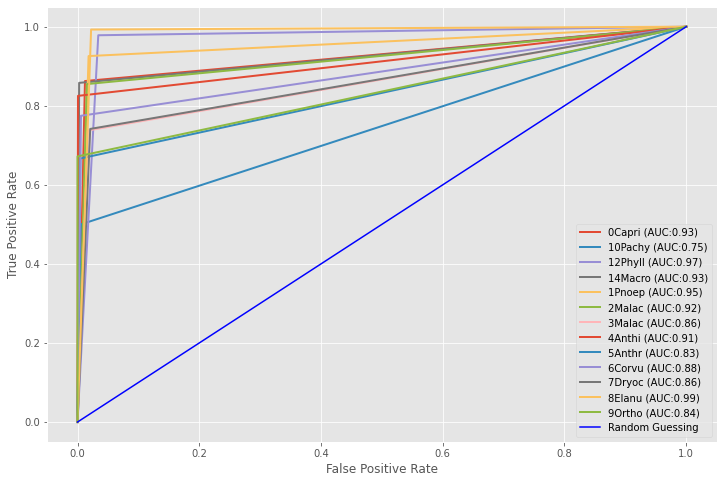

In [27]:
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, y_preds, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_preds = lb.transform(y_pred)

    for (idx, c_label) in enumerate(target_names1):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_preds[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)), linewidth=2)
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_test, y_preds, average=average)


print('ROC AUC score:', multiclass_roc_auc_score(test_set.classes, pred))

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()

# Top 1 and Top 5 Accuracy

In [19]:
top_k_accuracy_score(test_set.classes, pred, k=5)

0.9616270145817345

In [20]:
top_k_accuracy_score(test_set.classes, pred, k=5, normalize=False)

1253

In [21]:
top_k_accuracy_score(test_set.classes, pred, k=1)

0.8564850345356869

In [22]:
top_k_accuracy_score(test_set.classes, pred, k=1, normalize=False)

1116

# Save Model weight

In [23]:
model.save('/content/drive/MyDrive/Birddata_split/M1_rmsprop_1.hdf5')

In [24]:
finalpreds = pd.DataFrame(y_pred)
finalpreds.to_csv('/content/drive/MyDrive/Birddata_split/M1_rmsprop_1.csv',index=False)